# DE endcrine diabetes
- DE in each ct in T1D and T2D
- remove genes likely DE to ambience
- compare DE results across cts and diabetes types

In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import pickle

from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb
import upsetplot as usp
from matplotlib.patches import Patch
import venn 

from sklearn.preprocessing import minmax_scale,maxabs_scale

import diffxpy.api as de
from diffxpy.testing.det import DifferentialExpressionTestWald

from statsmodels.stats.multitest import multipletests

from scipy.cluster.hierarchy import linkage,dendrogram,fcluster,leaves_list
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

import sys
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/')
import helper as h
import importlib
importlib.reload(h)
import helper as h
sys.path.insert(0, '/lustre/groups/ml01/code/karin.hrovatin/diabetes_analysis/data_exploration/')
import helper_diffxpy as hde
importlib.reload(hde)
import helper_diffxpy as hde

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython

import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

from rpy2.robjects.packages import importr
grdevices = importr('grDevices')

In [2]:
%%R
library('ComplexHeatmap')
library(viridis)
library(proxy)
library(seriation)
library(dendextend)

In [3]:
ro.r('library(edgeR)')
ro.r('library("hypeR")')
ro.r("source(paste(Sys.getenv('WSC'),'diabetes_analysis/data_exploration/','helper_hypeR.R',sep=''))")

value,[RTYPES.CLOSXP]
visible,[RTYPES.LGLSXP]


In [2]:
path_data='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/'
path_save_r='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/deR_endocrine/'
path_fig='/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/figures/paper/'

In [3]:
# Load only gene info
adata_full=sc.read(path_data+'data_integrated_analysed.h5ad',backed='r')
var=adata_full.raw.var.copy()
del adata_full

In [4]:
# Add full gene symbol info
var['gene_symbol']=h.get_symbols(var.index)
# Check that gene symbols not nan 
if (var.gene_symbol=='nan').sum() :
        raise ValueError('Some gene symbols are nan - requires different parsing')

In [ ]:
# Load adata
adata_full=sc.read(path_data+'data_integrated_analysed.h5ad')

### Create pseudobulk
Using endocrine cell types and studies that contain both healthy and diabetes model cells. Pseudobulk is created as study-ct-health/diabetes_group-sex.

Subset to endocine cell types

In [57]:
# Ct col
ct_col='cell_type_integrated_v1'

In [58]:
# Subset to endocrine cells
adata = adata_full[adata_full.obs[ct_col].isin(['alpha','beta','delta','gamma']),:]
print(adata.obs[ct_col].unique())

['beta', 'delta', 'alpha', 'gamma']
Categories (4, object): ['alpha', 'beta', 'delta', 'gamma']


Exclude samples not used for DE (include studies with healthy and diabetic model samples). Use NOD 8w as healthy adult due to being in the same cluster as STZ control.

In [59]:
# Define cell groups and samples used for them
# Omit unused samples
groups_map={
 'Fltp_adult_mouse1_head_Fltp-':'adult',
 'Fltp_adult_mouse2_head_Fltp+':'adult',
 'Fltp_adult_mouse4_tail_Fltp+':'adult',
 'Fltp_adult_mouse3_tail_Fltp-':'adult',
 'NOD_elimination_SRR7610300_14w':'T1D',
 'NOD_elimination_SRR7610299_14w':'T1D',
 'NOD_elimination_SRR7610303_16w':'T1D',
 'NOD_elimination_SRR7610297_8w':'adult',
 'NOD_elimination_SRR7610298_14w':'T1D',
 'NOD_elimination_SRR7610301_16w':'T1D',
 'NOD_elimination_SRR7610295_8w':'adult',
 'NOD_elimination_SRR7610302_16w':'T1D',
 'NOD_elimination_SRR7610296_8w':'adult',
 'VSG_MUC13639_sham_Lepr-/-':'T2D',
 'VSG_MUC13633_chow_WT':'adult',
 'VSG_MUC13634_chow_WT':'adult',
 'VSG_MUC13641_sham_Lepr-/-':'T2D',
 'STZ_G2_STZ':'T2D',
 'STZ_G1_control':'adult',
       }
# Subset data to selected samples
adata = adata[adata.obs['study_sample_design'].isin(groups_map.keys()),:]
print(adata.obs['study_sample_design'].unique())

['Fltp_adult_mouse1_head_Fltp-', 'Fltp_adult_mouse2_head_Fltp+', 'Fltp_adult_mouse4_tail_Fltp+', 'Fltp_adult_mouse3_tail_Fltp-', 'NOD_elimination_SRR7610300_14w', ..., 'VSG_MUC13633_chow_WT', 'VSG_MUC13634_chow_WT', 'VSG_MUC13641_sham_Lepr-/-', 'STZ_G2_STZ', 'STZ_G1_control']
Length: 19
Categories (19, object): ['Fltp_adult_mouse1_head_Fltp-', 'Fltp_adult_mouse2_head_Fltp+', 'Fltp_adult_mouse3_tail_Fltp-', 'Fltp_adult_mouse4_tail_Fltp+', ..., 'VSG_MUC13633_chow_WT', 'VSG_MUC13634_chow_WT', 'VSG_MUC13639_sham_Lepr-/-', 'VSG_MUC13641_sham_Lepr-/-']


In [8]:
adata.shape

(70340, 13999)

In [60]:
# Add group info
adata.obs['group']=adata.obs.study_sample_design.map(groups_map)

Trying to set attribute `.obs` of view, copying.


Normalize data for pseudobulk DE

In [61]:
# Normalise
adata_norm=h.get_rawnormalised(adata.raw.to_adata(),sf_col='size_factors_integrated',
                               use_log=False,use_raw=False)

Pseudobulk per sample, cell type, disease group, and sex.

In [11]:
# Creat pseudobulk of study-ct-group-sex
xs=[]
obss=[]
for group,data in adata_norm.obs.groupby(['study',ct_col,'group','sex','study_sample_design']):
    xs.append(np.array(adata_norm[data.index,:].X.sum(axis=0)).ravel())
    # Make obs
    # make sure obss is str not int if clusters
    obs={'study':str(group[0]),'cell_type':str(group[1]),
                 'group':str(group[2]),'sex':str(group[3])}
    obss.append(obs)
xs=pd.DataFrame(np.array(xs),columns=adata_norm.var_names)
obss=pd.DataFrame(obss)

In [12]:
print('xs',xs.shape)
print('obss',obss.shape)

xs (91, 30672)
obss (91, 4)


### DE

In [13]:
group='group'

In [45]:
%%R -i xs -i obss -i group
# Creat object
y<-DGEList(counts = t(xs),  samples = obss)
print(dim(y))

[1] 30672    91


In [46]:
%%R
# remove lowly expressed genes
keep <- filterByExpr(y, group=y$samples[,group])
y<-y[keep, , keep.lib.sizes=FALSE]
print(dim(y))

[1] 13191    91


In [47]:
%%R
# Effective library size
y <- calcNormFactors(y)

In [48]:
# Build design matrix
dmat_loc=pd.DataFrame(index=obss.index)
dmat_loc['Intercept']=1


condition='cell_type'
for val_idx,val in enumerate(sorted(obss[condition].unique())):
    # Do not add ct factor beta (intercept) but do add group interactions with beta
    if val!='beta':
        dmat_loc.loc[obss[condition]==val,condition+'_'+str(val)]=1
    
    # Add group effect per ct
    condition_sub='group'
    for val_idx_sub,val_sub in enumerate(
        sorted([cl for cl in obss[condition_sub].unique() if cl!='adult'])):
        dmat_loc.loc[(obss[condition]==val).values & (obss[condition_sub]==val_sub).values,
                     condition+'_'+str(val)+'_'+condition_sub+'_'+str(val_sub)]=1

condition='sex'
for val_idx,val in enumerate(
    sorted([cl for cl in obss[condition].unique() if cl!='male'])):
    dmat_loc.loc[obss[condition]==val,condition+'_'+str(val)]=1

condition='study'
for val_idx,val in enumerate(
    sorted([cl for cl in obss[condition].unique() if cl!='STZ'])):
    dmat_loc.loc[obss[condition]==val,condition+'_'+str(val)]=1

dmat_loc.fillna(0,inplace=True)
dmat_loc=dmat_loc.astype('float')

print('dmat_loc')
display(dmat_loc)

dmat_loc


,Intercept,cell_type_alpha,cell_type_alpha_group_T1D,cell_type_alpha_group_T2D,cell_type_beta_group_T1D,cell_type_beta_group_T2D,cell_type_delta,cell_type_delta_group_T1D,cell_type_delta_group_T2D,cell_type_gamma,cell_type_gamma_group_T1D,cell_type_gamma_group_T2D,sex_female,study_Fltp_adult,study_NOD_elimination,study_VSG
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
88,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
89,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [49]:
# Add design to R and name rows
ro.globalenv['design']=dmat_loc
ro.r('row.names(design)<-row.names(y$samples)')
ro.r('design')

,Intercept,cell_type_alpha,cell_type_alpha_group_T1D,cell_type_alpha_group_T2D,cell_type_beta_group_T1D,cell_type_beta_group_T2D,cell_type_delta,cell_type_delta_group_T1D,cell_type_delta_group_T2D,cell_type_gamma,cell_type_gamma_group_T1D,cell_type_gamma_group_T2D,sex_female,study_Fltp_adult,study_NOD_elimination,study_VSG
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
87,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
88,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
89,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
%%R
# Robust dispersion 
y <- estimateGLMRobustDisp(y, design)

In [ ]:
%%R
# Fit - GLM not QL as used robust dispersion
fit <- glmFit(y, design)

In [63]:
%R fit$design

array([[1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 1.]])

In [57]:
# Get DE tables - compare T1D/T2D to healthy in individual cts
summaries={}
for cl in ['T1D','T2D']:
    summaries_cl={}
    for ct in ['alpha','beta','gamma','delta']:
        # Coef2 in python indexing format
        coef2=np.argwhere(dmat_loc.columns=='cell_type_'+ct+'_group_'+str(cl))[0][0]
        # Coef 1 is not needed if not existing as then testing signif of coef2 only 
        # (compared to intercept, should not be added explicitly!!!)
        # If coef1 is present then compare coef1 and coef2
        coef1=np.argwhere(dmat_loc.columns=='cell_type_'+ct)
        if len(coef1)>0:
            coef1=coef1[0][0]
            contrast=np.zeros(dmat_loc.shape[1])
            contrast[coef1]=-1
            contrast[coef2]=1
            print('Cl',cl,'ct',ct,'coef1',coef1,'coef2',coef2)
            print('Constrast',contrast)
            ro.globalenv['contrast']=contrast
            res=ro.r('glmLRT(fit, contrast=contrast)$table')
        else:
            print('Cl',cl,'ct',ct,'coef2',coef2)
            coef2=coef2+1
            # Coef2 in R indexing format
            print('coef2 R',coef2)
            ro.globalenv['coef2']=coef2
            res=ro.r('glmLRT(fit, coef=coef2)$table')
        # Add padj
        res['padj']=multipletests(res["PValue"].values, alpha=0.05, method='fdr_bh')[1]
        summaries_cl[ct]=res
    summaries[cl]=summaries_cl

Cl T1D ct alpha coef1 1 coef2 2
Constrast [ 0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Cl T1D ct beta coef2 4
coef2 R 5
Cl T1D ct gamma coef1 9 coef2 10
Constrast [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.]
Cl T1D ct delta coef1 6 coef2 7
Constrast [ 0.  0.  0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
Cl T2D ct alpha coef1 1 coef2 3
Constrast [ 0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Cl T2D ct beta coef2 5
coef2 R 6
Cl T2D ct gamma coef1 9 coef2 11
Constrast [ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.]
Cl T2D ct delta coef1 6 coef2 8
Constrast [ 0.  0.  0.  0.  0.  0. -1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


#### Save

In [6]:
file=path_save_r+'endo_'
file

'/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/deR_endocrine/endo_'

In [30]:
%%R -i file
# Save fits
save(y,fit,file=paste0(file,'fits.RData'))

In [13]:
#%%R -i file
# Reload
#load(file=paste0(file,'fits.RData'))

In [58]:
# Save summary tables
pickle.dump(summaries,open(file+'summaries.pkl','wb'))

In [7]:
# Reload results
#summaries=pickle.load(open(file+'summaries.pkl','rb'))

## Analyse results

In [15]:
ALFC=1
FDR=0.05

N DE in different cts and diabetes types

T1D alpha : fdr 0.05 , abs(lfc) >  1 : up 1923 down 1519
T1D beta : fdr 0.05 , abs(lfc) >  1 : up 745 down 544
T1D gamma : fdr 0.05 , abs(lfc) >  1 : up 1402 down 1220
T1D delta : fdr 0.05 , abs(lfc) >  1 : up 1452 down 1580
T2D alpha : fdr 0.05 , abs(lfc) >  1 : up 1374 down 1144
T2D beta : fdr 0.05 , abs(lfc) >  1 : up 1159 down 802
T2D gamma : fdr 0.05 , abs(lfc) >  1 : up 905 down 773
T2D delta : fdr 0.05 , abs(lfc) >  1 : up 1117 down 1131


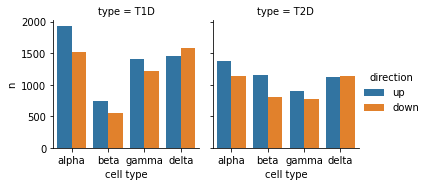

In [93]:
# N DE
de_summary=[]
for name,summaries_sub in summaries.items():
    for name_sub,summary in summaries_sub.items():
        n_up=summary.query('padj<@FDR & logFC>@ALFC').shape[0]
        n_down=summary.query('padj<@FDR & logFC<-@ALFC').shape[0]
        print(name,name_sub,': fdr',FDR,', abs(lfc) > ',ALFC,':',
          'up',n_up, 'down',n_down)
        de_summary.append({'type':name,'cell type':name_sub,'direction':'up','n':n_up})
        de_summary.append({'type':name,'cell type':name_sub,'direction':'down','n':n_down})
de_summary=pd.DataFrame(de_summary)
sb.catplot(x='cell type',y='n',hue='direction',col='type',data=de_summary,
            kind="bar", height=2.5, aspect=1)

Look at example genes - genes shared up in T1D accross cts.

In [88]:
# Top UP T1D shared genes
genes_shared=set()
for summary in summaries['T1D'].values():
    genes_res=set(summary.query('padj<0.05 & logFC>2').index)
    if len(genes_shared)==0:
        genes_shared=genes_res
    else:
        genes_shared=genes_shared&genes_res
adata.raw.var.loc[genes_shared, 'gene_symbol']

EID
ENSMUSG00000031896             Ctrl
ENSMUSG00000062478             Ctrc
ENSMUSG00000026818              Cel
ENSMUSG00000090942    F830016B08Rik
ENSMUSG00000005268             Prlr
ENSMUSG00000060586           H2-Eb1
ENSMUSG00000040205            Cuzd1
ENSMUSG00000046008            Pnlip
ENSMUSG00000026104            Stat1
ENSMUSG00000036938             Try5
ENSMUSG00000059654             Reg1
ENSMUSG00000073409            H2-Q6
ENSMUSG00000030707           Coro1a
ENSMUSG00000079478            Znrd2
ENSMUSG00000064220           H2ac18
ENSMUSG00000011463             Cpb1
ENSMUSG00000027690           Slc2a2
ENSMUSG00000035896           Rnase1
ENSMUSG00000060143          Gm10076
ENSMUSG00000005232            G6pc2
ENSMUSG00000026417             Pigr
ENSMUSG00000069874            Irgm2
ENSMUSG00000042179         Pnliprp1
ENSMUSG00000054106             Try4
ENSMUSG00000031957            Ctrb1
ENSMUSG00000029561            Oasl2
ENSMUSG00000105504             Gbp5
ENSMUSG00000049350      

C: Many top DE genes are ambient (acinar, immune,...).

### Mark potential ambient DE genes
The DE results seem to contain ambient DE genes (se example above). Assign as potential ambient if a gene clusters is relatively highly expressed in other cts.

Cluster genes based on expression across cell clusters in alas. In each cell type DE result remove genes relatively lowly expressed in that cell type compared to other cell types.

In [52]:
# Load rawnorm. Correctly norm expression is in layers X_sf_integrated
adata_rawnorm=sc.read(path_data+'data_rawnorm_integrated_annotated.h5ad',backed='r')

#### Cell clustering
Cluster cells and assign them to endocrine cell types. Clustering is performed as cells may be heterogeneous within cell type (e.g. beta cell in healthy/diabetes) thus differently expressing genes and contributing to ambience.

In [13]:
cl_col_full='leiden_r2'
adata_rawnorm.obs[cl_col_full]=adata_full.obs[cl_col_full]

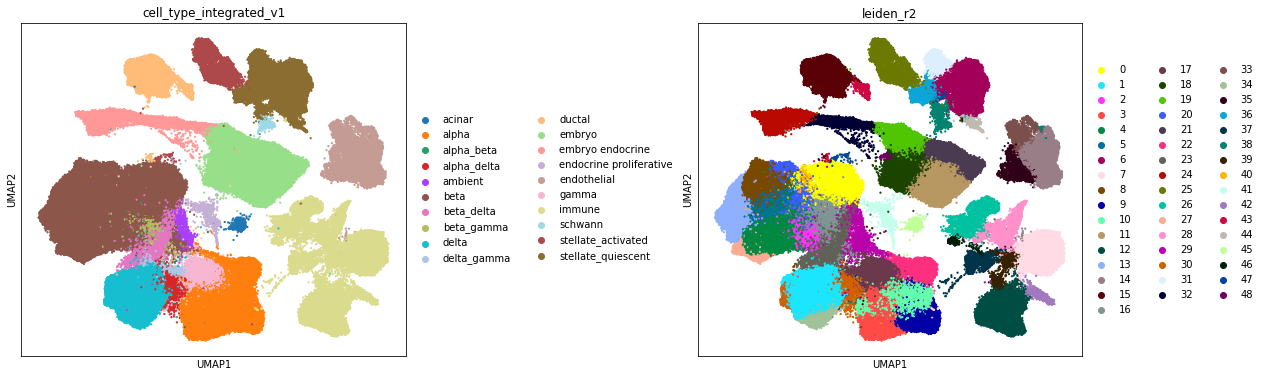

In [17]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(adata_full,color=[ct_col,cl_col_full],s=20,wspace=0.6)

Most common ct in each cl and its ratio

In [14]:
# Most common ct ratio per cl
main_ct=adata_full.obs.groupby(cl_col_full).apply(lambda x: x[ct_col].value_counts(normalize=True
                                                                          ).head(n=1))
display(main_ct)

leiden_r2                         
0          beta                       0.996583
1          delta                      0.977412
2          beta                       0.987390
3          alpha                      0.997339
4          beta                       0.996420
5          beta                       0.999119
6          stellate_quiescent         0.999754
7          immune                     0.999632
8          beta                       0.997646
9          alpha                      0.997068
10         alpha                      0.987334
11         embryo                     0.999706
12         immune                     1.000000
13         beta                       0.988441
14         endothelial                0.999439
15         ductal                     0.998144
16         beta                       0.753274
17         gamma                      0.936404
18         embryo                     0.999718
19         embryo                     0.963941
20         beta          

Other common cts in cls that are not composed predominately of one ct.

In [15]:
# Most common cts in each cl that is not composed mainly of one ct
unclean_cls=[cl for cl,ct in main_ct[main_ct<0.9].index]
adata_full[adata_full.obs[cl_col_full].isin(unclean_cls),:].\
    obs.groupby(cl_col_full).apply(lambda x: x[ct_col].value_counts(normalize=True
                                                                          ).head(n=3))

leiden_r2                    
16         beta                  0.753274
           beta_gamma            0.151740
           alpha_beta            0.073555
23         beta_delta            0.886048
           delta_gamma           0.055031
           delta                 0.022049
29         beta                  0.658960
           ambient               0.254031
           alpha                 0.040462
30         alpha_delta           0.556398
           delta                 0.402844
           delta_gamma           0.022117
38         stellate_quiescent    0.531295
           schwann               0.448326
           endothelial           0.013828
47         stellate_activated    0.639785
           stellate_quiescent    0.338710
           beta                  0.016129
Name: cell_type_integrated_v1, dtype: float64

C: Most cell clusters are mainly composed of single cell type. There are a few exceptions. Those that are non-endo are not that relevant. Those that are endo mainly seem to be well represented by the main ct. Exceptions are cl 29 which may be low quality beta cells and ct 30 which may contain some delta cells besides alpha_delta.
Doublets will not be used as multiplet-contained cell types potentially contributing to ambience are also present as individual cell types. Embryo clusters will be removed from comparison as they for sure can not contribute to ambience. Cells from other samples will not be removed as they contribute to cell numbers of cell types and may help to resolve ambience.

In [16]:
# Map cl to most common ct
cl_ct_map=dict(main_ct.index)

#### Analyse expression of genes across cell clusters

Summarise cell clusters as pseudobulks

In [23]:
# Prepare pb across cell clusters

# DE genes across all comparisons
genes=set()
for summaries_sub in summaries.values():
    for summary in summaries_sub.values():
        genes.update(summary.query('padj<@FDR & abs(logFC)>@ALFC').index)
    
# Creat pseudobulk
adata_rawnorm.obs[cl_col_full]=adata_full.obs[cl_col_full]
xs1=[]
vnames1=[]
for group,data in adata_rawnorm.obs.groupby(cl_col_full):
    # Ignore mainly embryo cts
    if 'embryo' not in cl_ct_map[group]:
        xs1.append(np.array(adata_rawnorm[data.index,:
                                         ].layers['X_sf_integrated'].mean(axis=0)).ravel())
        # Make obs
        # make sure obss is str not int if clusters
        vnames1.append(group)
xs1=pd.DataFrame(maxabs_scale(np.array(xs1)),columns=adata_rawnorm.var_names,index=vnames1)
adata_genes=sc.AnnData(xs1.T)
# Map main cell ct to ct cls of adata genes
adata_genes.var['cell_type']=adata_genes.var.index.map(cl_ct_map)

Visualise expression for DE genes across cell clusters pseudobulk

In [ ]:
# Map of main ct per cl and cl to color based on main ct
ct_cmap=dict(zip(adata_full.obs[ct_col].cat.categories,adata_full.uns[ct_col+'_colors']))
# Remove embryo colors
ct_cmap={ct:c for ct,c in ct_cmap.items() if 'embryo' not in ct}
ctcl_cmap={cl:ct_cmap[ct] for cl,ct in main_ct.index if cl in adata_genes.var_names}

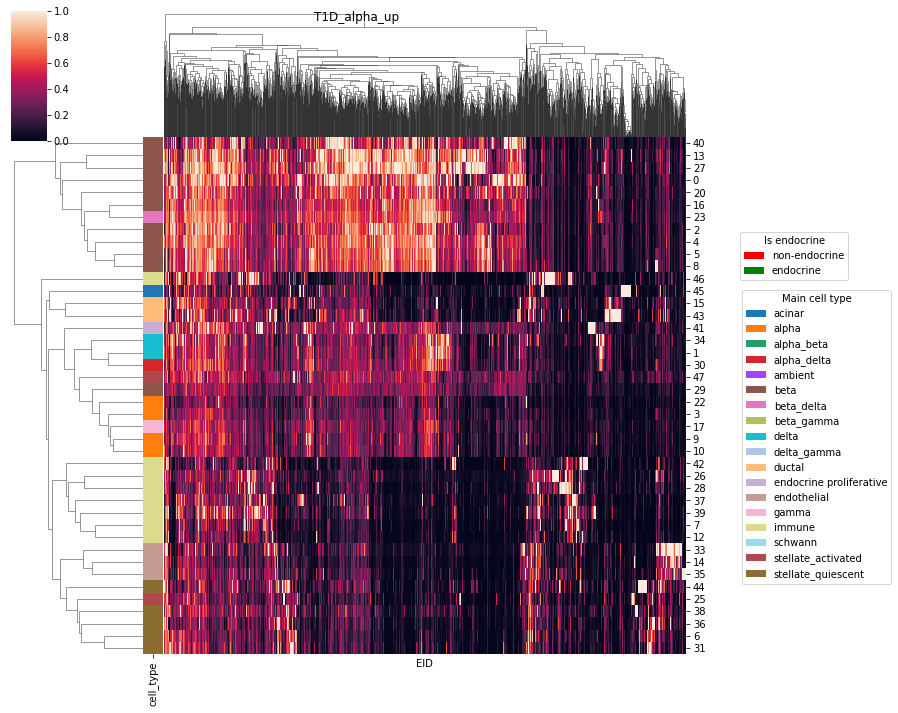

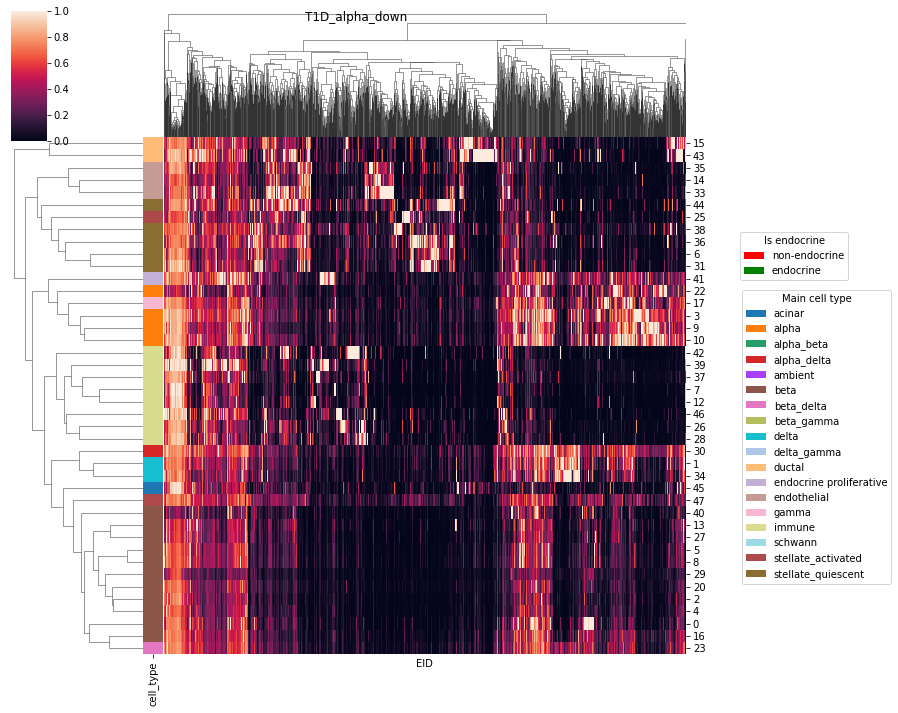

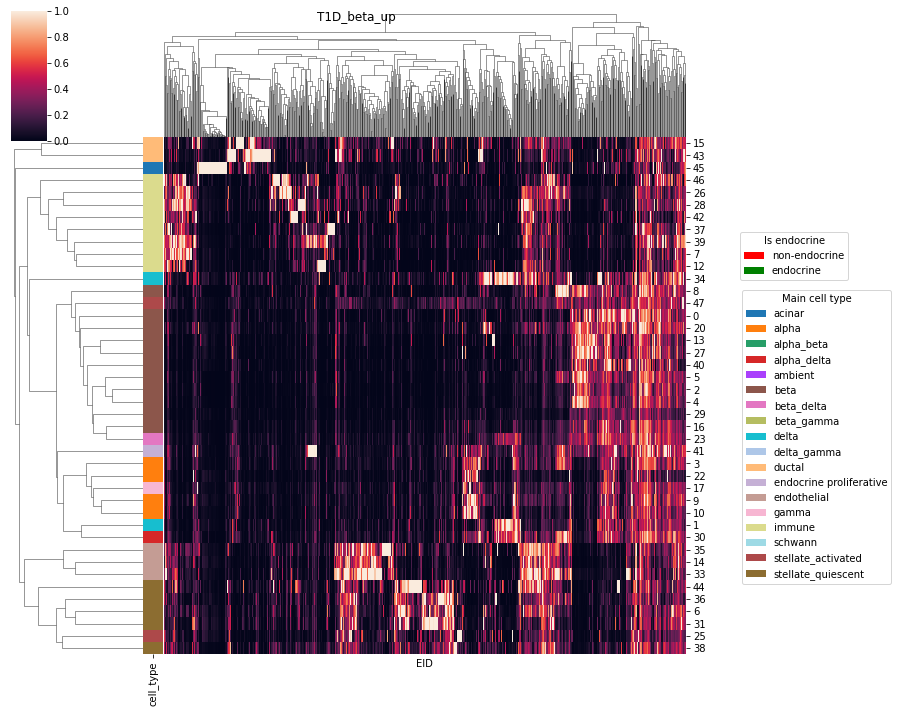

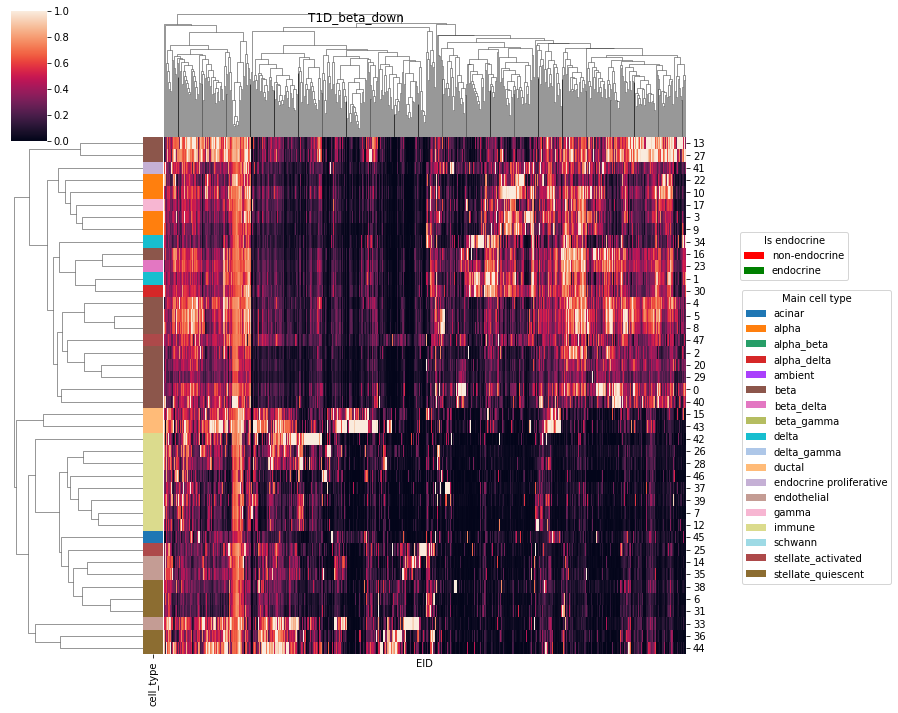

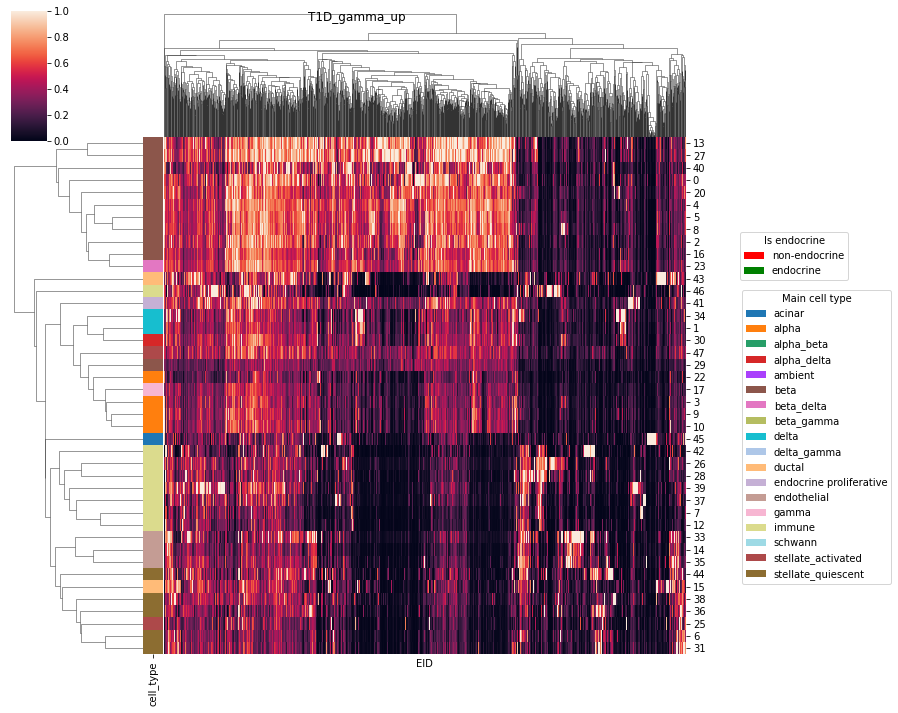

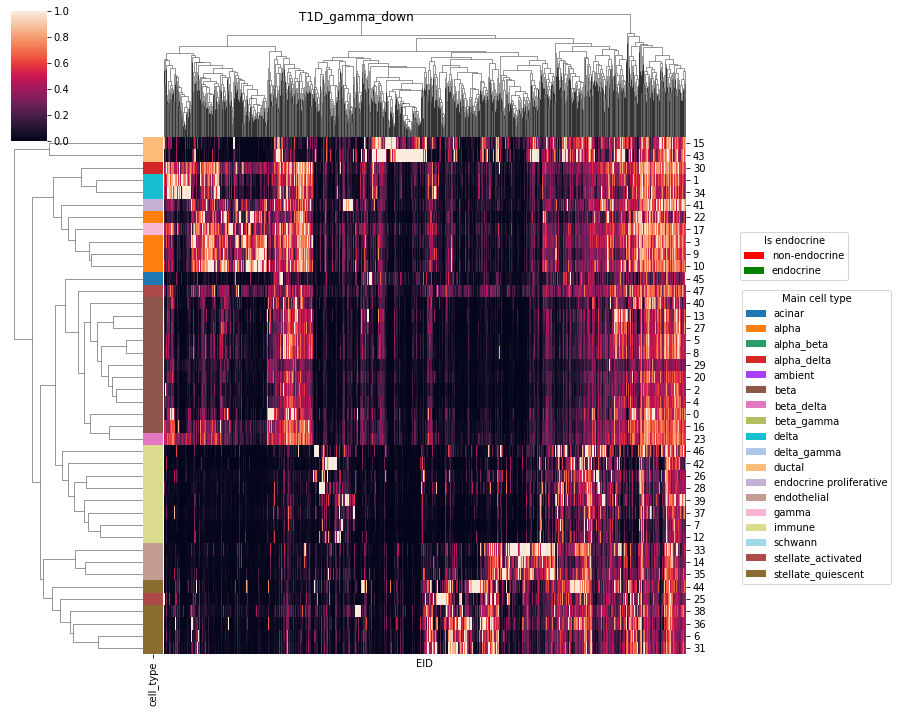

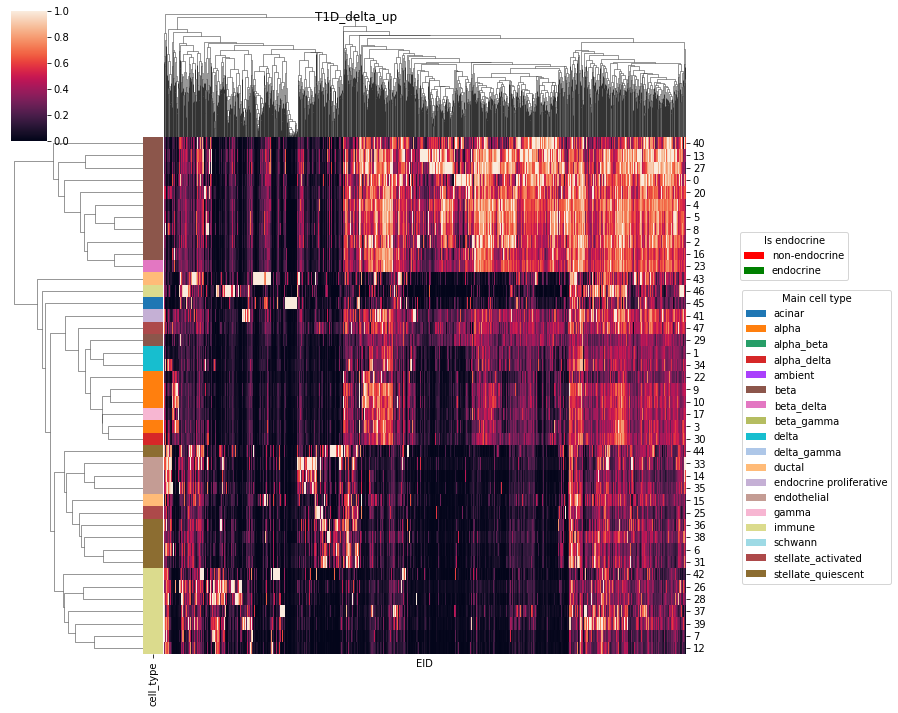

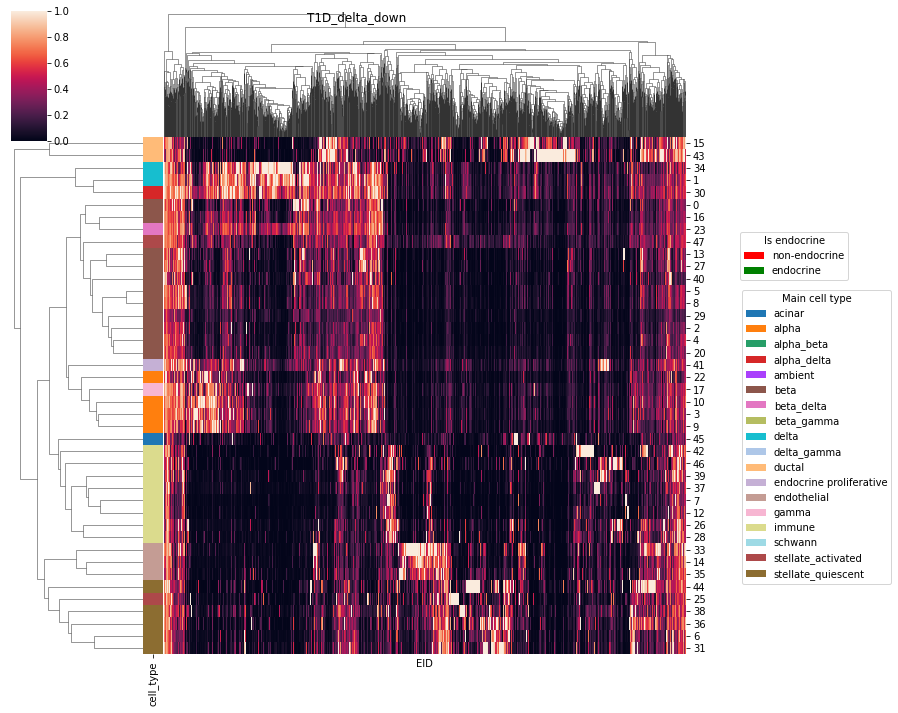

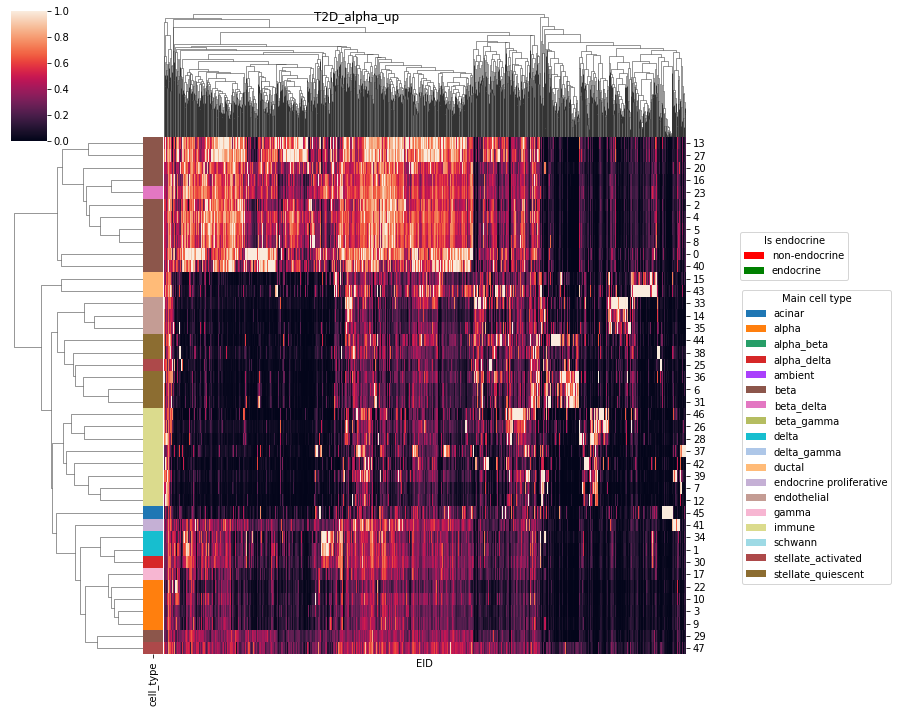

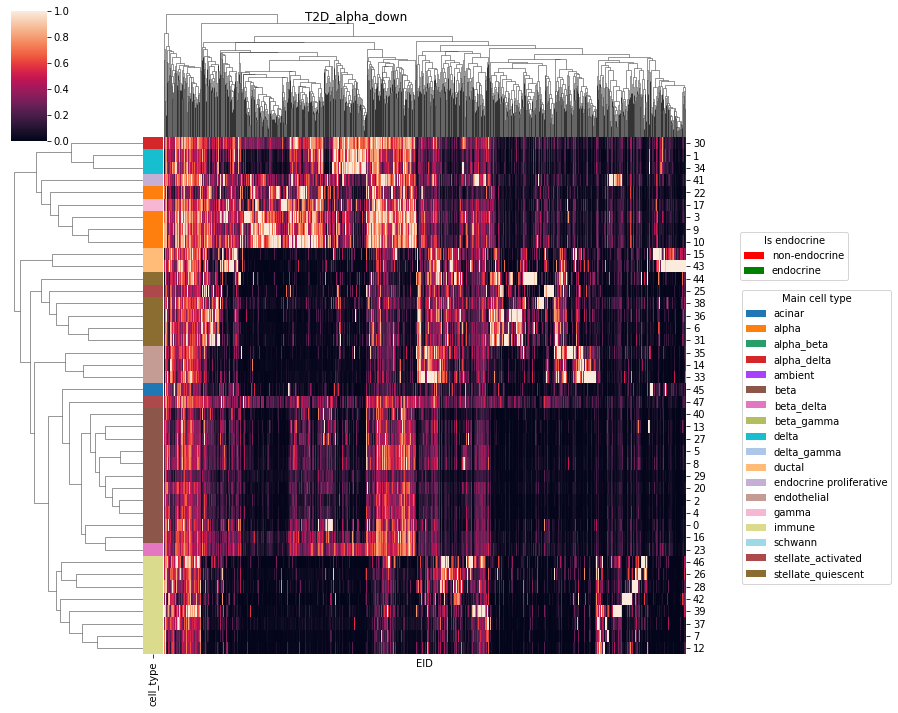

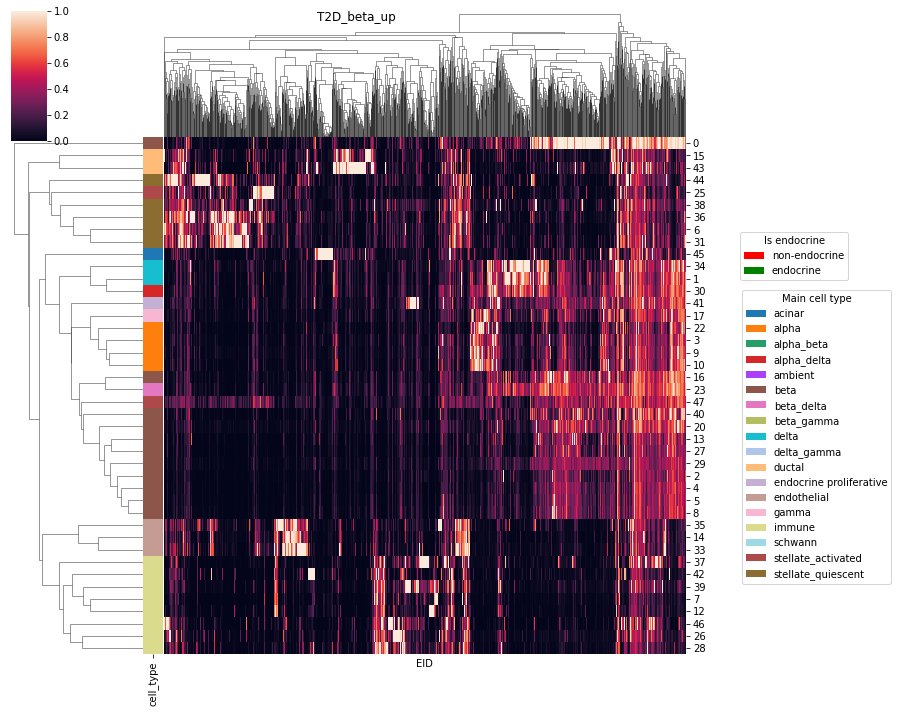

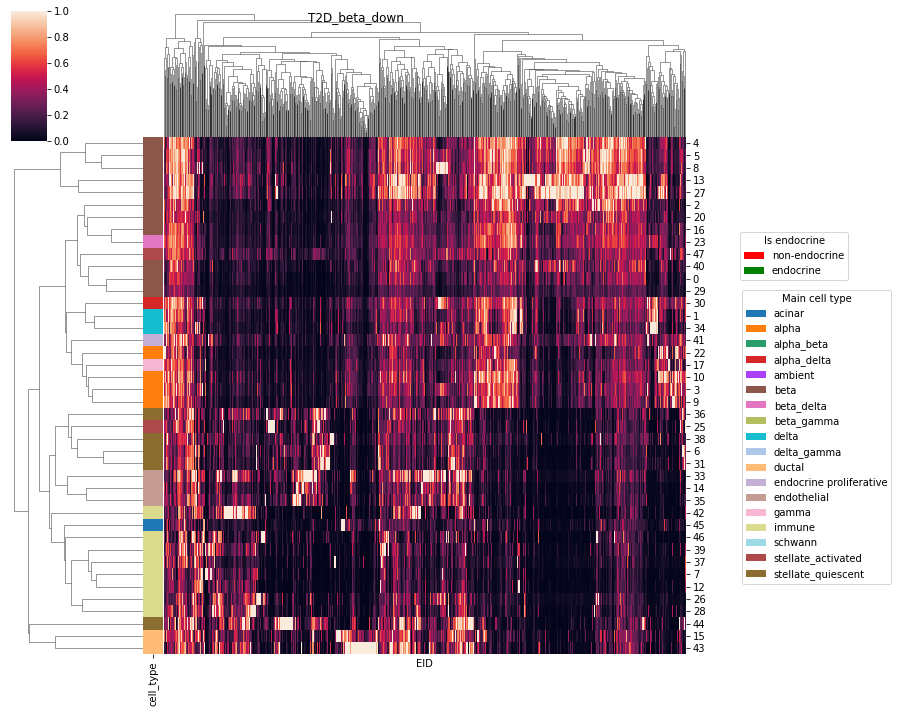

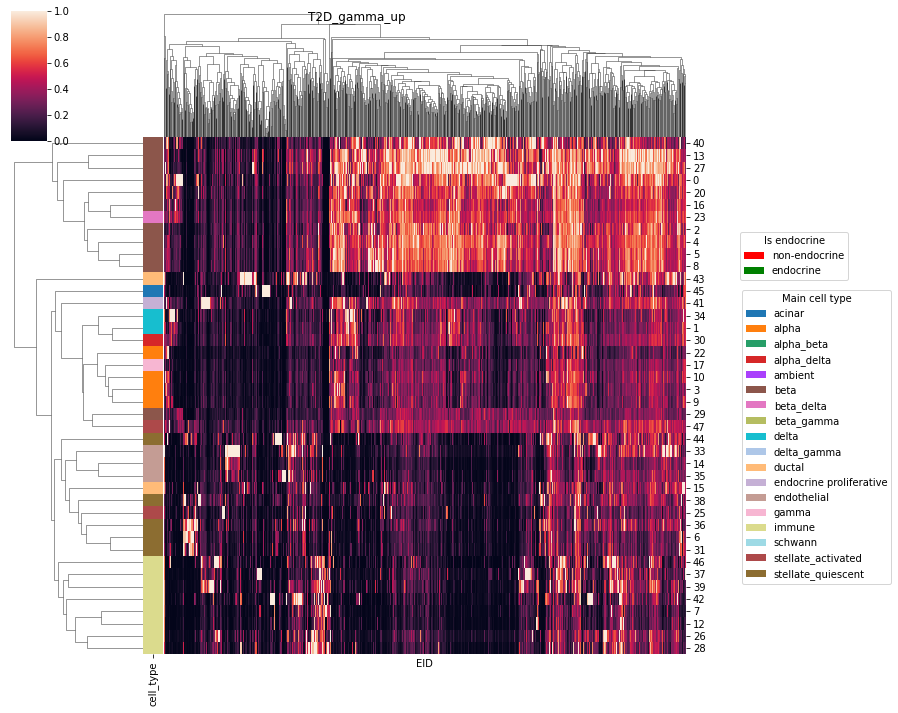

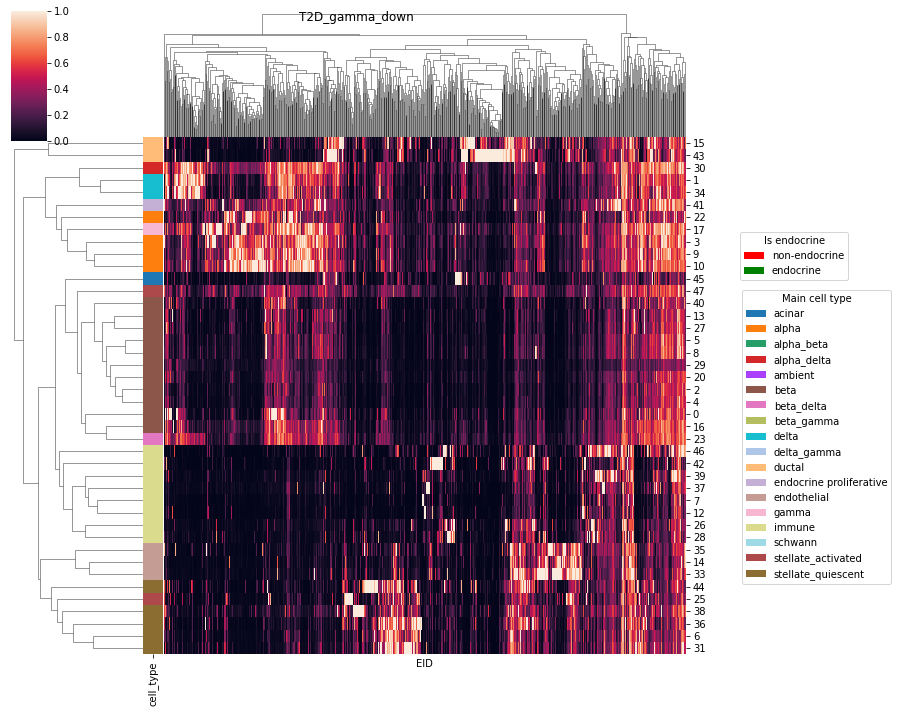

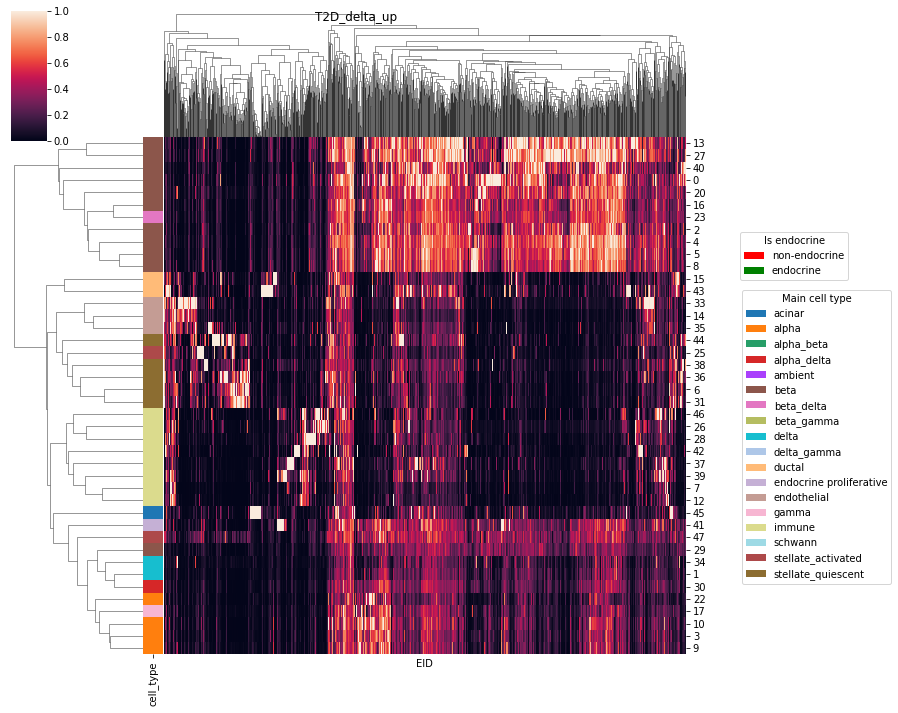

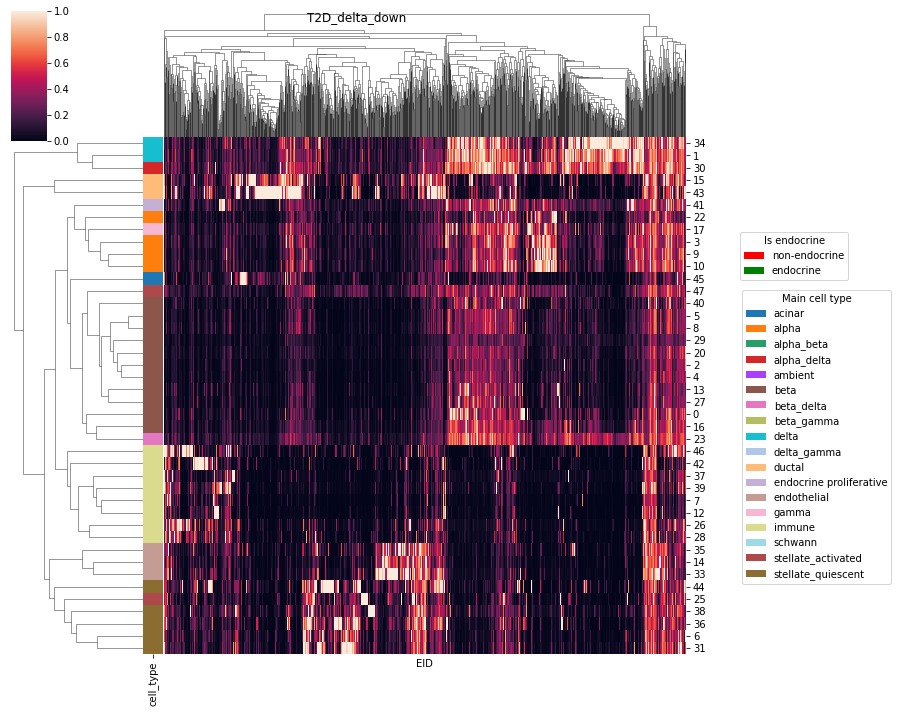

In [32]:
# Heatmap of DE genes expression across cell cls
for diabetes, summaries_sub in summaries.items():
    for ct,summary in summaries_sub.items():
        for direction,lfc_str in [('up','>'),('down','<-')]:
            name='_'.join([diabetes,ct,direction])
            genes=summary.query('padj<@FDR & logFC'+lfc_str+'@ALFC').index

            # Heatmap
            ad=adata_genes[genes,:]

            x_temp=pd.DataFrame( ad.X.T,
                                index=ad.var_names,columns=ad.obs_names)

            # Cell cl anno
            # Row colors for heatmap, containing cell type info
            row_colors=pd.DataFrame({
                        'cell_type':[ctcl_cmap[cl] for cl in adata_genes.var_names]
            },index=adata_genes.var_names)

            fg=sb.clustermap(x_temp, 
                          row_colors=row_colors,
                          col_cluster=True,row_cluster=True,
                         xticklabels=False, yticklabels=True)
             # Adds block annotation titles as axis labels
            # legend for cell types
            handles = [Patch(facecolor=c) for c in ct_cmap.values()]
            l2=plt.legend(handles, ct_cmap.keys(),
                          title='Main cell type',
                       bbox_to_anchor=(1.25, 0.6), bbox_transform=plt.gcf().transFigure)    
            # legend for endocrine
            handles = [Patch(facecolor=c) for c in ['r','g']]
            l3=plt.legend(handles, ['non-endocrine','endocrine'],
                          title='Is endocrine',
                       bbox_to_anchor=(1.19, 0.68), bbox_transform=plt.gcf().transFigure)   
            plt.gca().add_artist(l2)
            fg.fig.suptitle(name)
            del ad
            del x_temp

C: Issue: It could also happen that gene is expressed in e.g. alpha&beta but only de in beta and thus due to ambience also de in alpha

C: It seems that using 29 as beta and 30 as alpha_delta will not be problematic in terms of adding additional genes to beta or missing delta genes, respectively.

To each DE summary (e.g. cell type from DE) add relative expression of genes in that ct compared to other ts based on max relative expression across clusters that are associated with ct of the summary.

In [25]:
# Add  relative expression of relevant ct to summary
for summaries_sub in summaries.values():
    for ct, summary in summaries_sub.items():
        summary['relative_ct_expression']=adata_genes[
            summary.index,adata_genes.var.cell_type==ct].X.max(axis=1)

In [26]:
# Save summary tables with additional info on relative ct expression
if True:
    pickle.dump(summaries,open(file+'summaries.pkl','wb'))

For DE genes check distn of relative expr scores

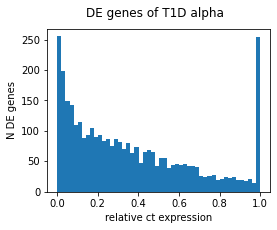

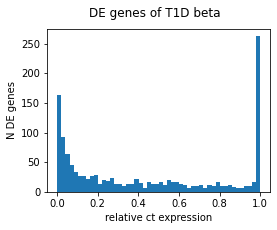

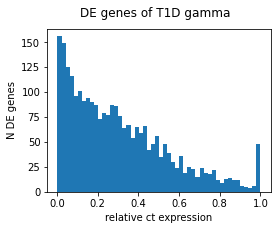

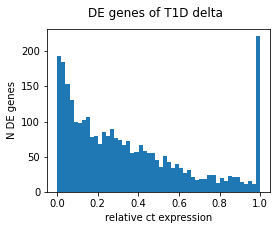

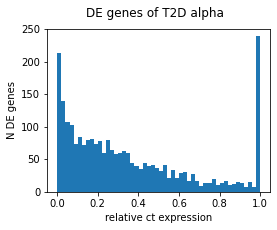

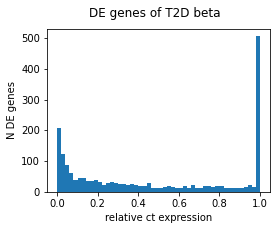

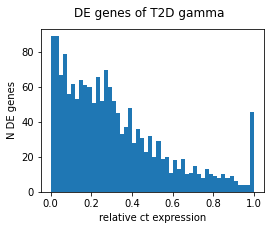

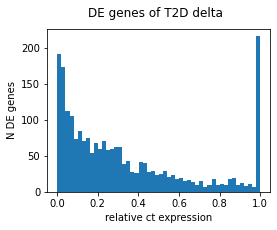

In [34]:
# Distribution of relative expression scores of DE genes
for diabetes,summaries_sub in summaries.items():
    for ct,summary in summaries_sub.items():
        fig,ax=plt.subplots(figsize=(4,3))
        plt.hist(summary.query('padj<@FDR & abs(logFC)>@ALFC')['relative_ct_expression'],
                 bins=50)
        fig.suptitle('DE genes of '+diabetes+' '+ct)
        ax.set_xlabel('relative ct expression')
        ax.set_ylabel('N DE genes')

### Analyse DE with relative expression threshold
Also use relative expression threshold for selecting significant genes to remove potential ambient effects.

T1D alpha : fdr 0.05 , abs(lfc) >  1 : up 1397 down 1201
T1D beta : fdr 0.05 , abs(lfc) >  1 : up 402 down 496
T1D gamma : fdr 0.05 , abs(lfc) >  1 : up 1026 down 958
T1D delta : fdr 0.05 , abs(lfc) >  1 : up 1026 down 1258
T2D alpha : fdr 0.05 , abs(lfc) >  1 : up 934 down 955
T2D beta : fdr 0.05 , abs(lfc) >  1 : up 725 down 722
T2D gamma : fdr 0.05 , abs(lfc) >  1 : up 651 down 651
T2D delta : fdr 0.05 , abs(lfc) >  1 : up 663 down 937


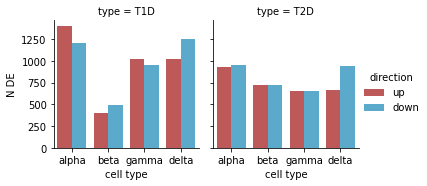

In [115]:
# DE N
rce=0.1
de_summary=[]
for name,summaries_sub in summaries.items():
    for name_sub,summary in summaries_sub.items():
        n_up=summary.query('padj<@FDR & logFC>@ALFC & relative_ct_expression>@rce').shape[0]
        n_down=summary.query('padj<@FDR & logFC<-@ALFC & relative_ct_expression>@rce').shape[0]
        print(name,name_sub,': fdr',FDR,', abs(lfc) > ',ALFC,':',
          'up',n_up, 'down',n_down)
        de_summary.append({'type':name,'cell type':name_sub,'direction':'up','N DE':n_up})
        de_summary.append({'type':name,'cell type':name_sub,'direction':'down','N DE':n_down})
de_summary=pd.DataFrame(de_summary)
sb.catplot(x='cell type',y='N DE',hue='direction',col='type',data=de_summary,
            kind="bar", height=2.5, aspect=1,palette=['#cf4848','#49b1de'])
plt.savefig(path_fig+'barplot_atlas_endoDEn.png',dpi=300,bbox_inches='tight')

Compare DE genes overlaps accross cts at different relative expr thresholds.

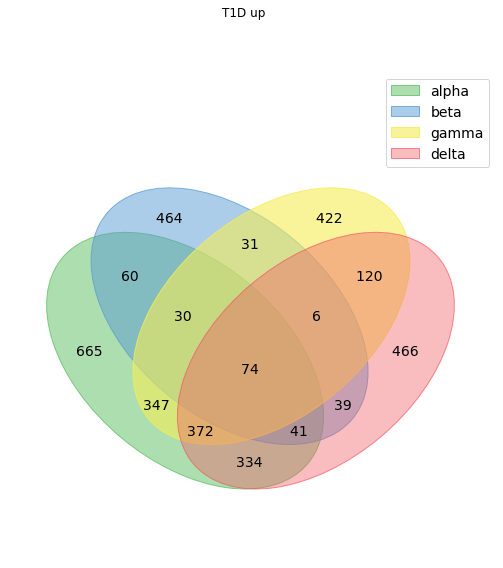

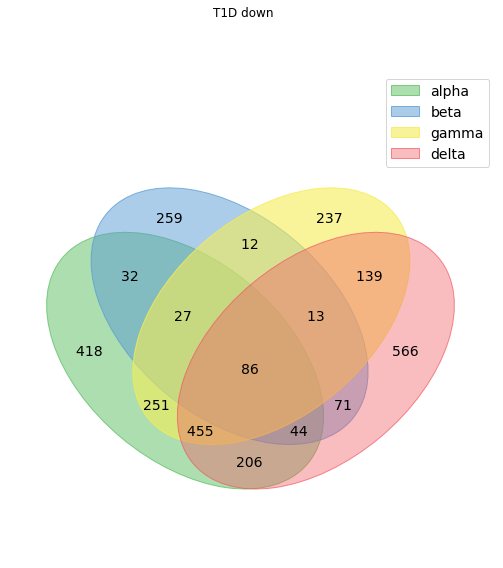

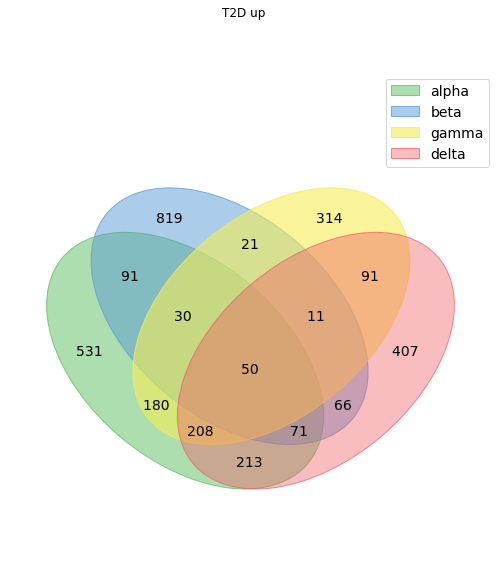

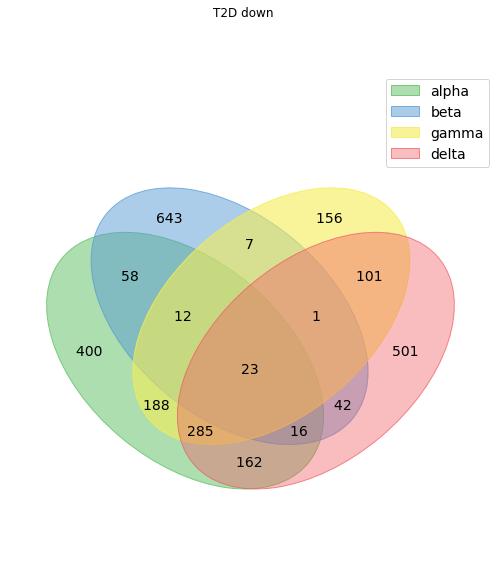

In [153]:
# Plot DE gene venn
rce=0.1
for diabetes in summaries.keys():
    for direction,lfc_str in [('up','>'),('down','<-')]:
        labels=[]
        names=[]
        for ct,summary in summaries[diabetes].items():
            de=set(summary.query(
                'padj<@FDR & logFC'+lfc_str+'@ALFC & relative_ct_expression>@rce').index)
            labels.append(de)
            names.append(ct)
        labels = venn.get_labels(labels, fill=['number'])
        fig, ax = venn.venn4(labels, names=names)
        fig.show()
        fig.suptitle(diabetes+' '+direction)

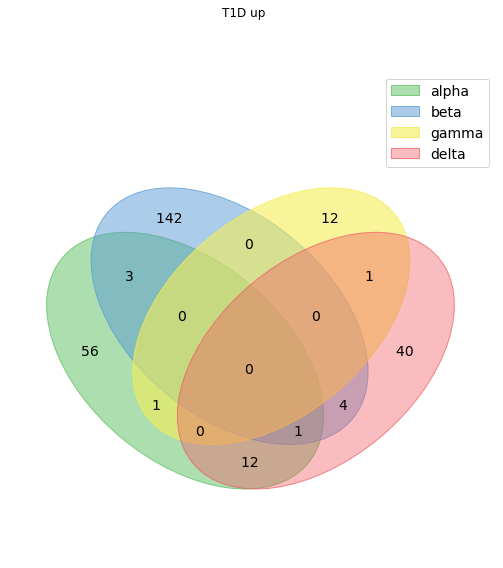

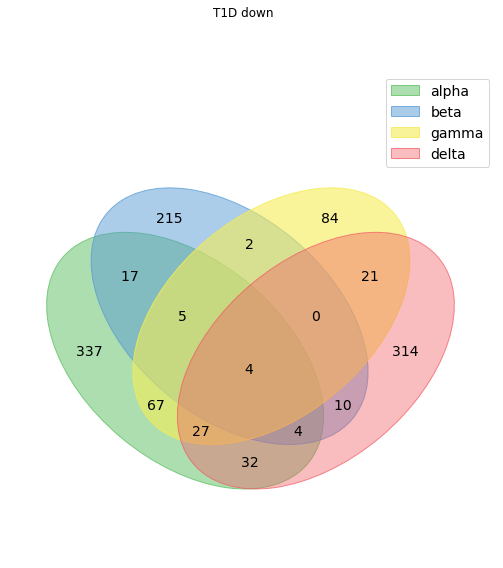

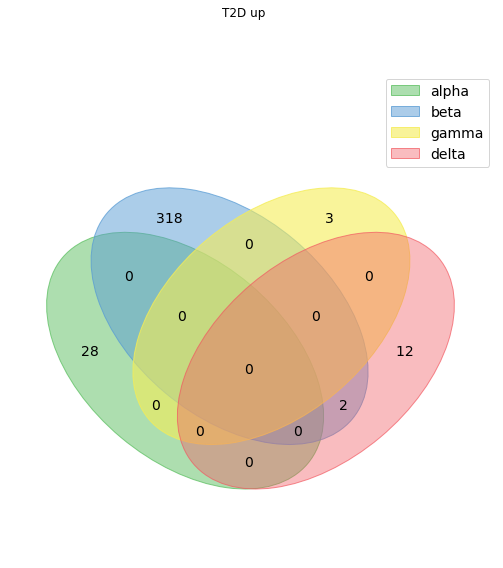

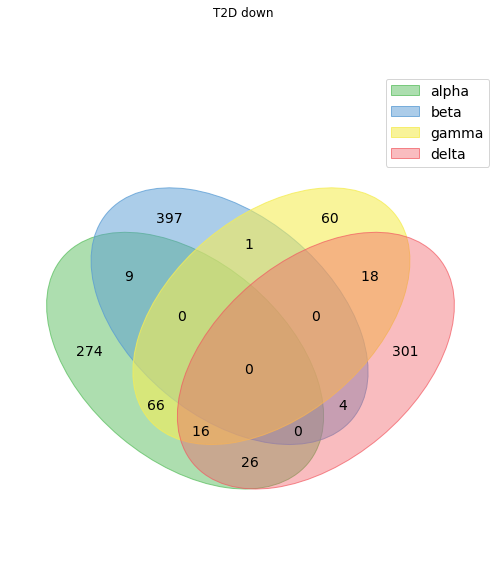

In [40]:
# Plot DE gene venn
rce=0.7
for diabetes in summaries.keys():
    for direction,lfc_str in [('up','>'),('down','<-')]:
        labels=[]
        names=[]
        for ct,summary in summaries[diabetes].items():
            de=set(summary.query(
                'padj<@FDR & logFC'+lfc_str+'@ALFC & relative_ct_expression>@rce').index)
            labels.append(de)
            names.append(ct)
        labels = venn.get_labels(labels, fill=['number'])
        fig, ax = venn.venn4(labels, names=names)
        fig.show()
        fig.suptitle(diabetes+' '+direction)

C: Both when using low and high relative ct expr thr most overlap is betwen non-beta endoc cells and less with beta and other endo. Thus lack of beta-other endo overlap is likely not just due to effect of beta high expr and thus filtering out true genes in other cts as ambient by mistake.

Show lFC for just hormone genes

In [15]:
for ct,genes in [('alpha',['Gcg']),('beta',['Ins1','Ins2']),
                 ('delta',['Sst']),('gamma',['Ppy'])]:
    print('\n',ct)
    for td, summaries_ct in summaries.items():
        print(td)
        res_sub=summaries_ct[ct].loc[var.query('gene_symbol in @genes').index,
                                     :][['logFC','padj']].copy()
        res_sub['gene_symbol']=var.loc[res_sub.index,'gene_symbol']
        display(res_sub)


 alpha
T1D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000000394,-7.159595,5.538216e-19,Gcg


T2D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000000394,-5.476905,3.497432e-08,Gcg



 beta
T1D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000000215,1.451740,4.782832e-07,Ins2
ENSMUSG00000035804,1.672934,1.714254e-09,Ins1


T2D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000000215,-0.051029,0.912058,Ins2
ENSMUSG00000035804,-1.151546,0.001019,Ins1



 delta
T1D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000004366,-7.426182,7.932762e-39,Sst


T2D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000004366,-4.610265,7.581069e-11,Sst



 gamma
T1D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000017316,-7.348328,1.905844e-17,Ppy


T2D


,logFC,padj,gene_symbol
EID,,,
ENSMUSG00000017316,-6.499044,6.923883e-09,Ppy


Overlap between DE tests, accounting for direction of DE (conunt genes as overlapping if DE in the same direction in both groups). Compute overlap with Jaccard index.

In [73]:
# Extract DE
rce=0.1
de_combined=pd.DataFrame()
for name,summaries_sub in summaries.items():
    for name_sub,summary in summaries_sub.items():
        for direction,lfc_str in [('up','>'),('down','<-')]:
            for g in summary.query(
                'padj<@FDR & logFC'+lfc_str+'@ALFC & relative_ct_expression>@rce').index:
                de_combined.at[g,name+'_'+name_sub]=direction

In [90]:
# Overlap of DE genes, accounting for direction
overlap=pd.DataFrame()
for idx1 in range(de_combined.shape[1]-1):
    for idx2 in range(idx1+1,de_combined.shape[1]):
        name1=de_combined.columns[idx1]
        name2=de_combined.columns[idx2]
        # Nan is not taken as equal in series comparison
        # Ratio of smaller
        #n=(de_combined[name1]==de_combined[name2]).sum()/min(
        #    (~de_combined[name1].isna()).sum(), (~de_combined[name2].isna()).sum())
        # Jaccard
        n=(de_combined[name1]==de_combined[name2]).sum()/len(
            set(de_combined[name1].dropna().index)|set(de_combined[name2].dropna().index))
        overlap.at[name1,name2]=n
        overlap.at[name2,name1]=n
overlap=overlap.fillna(1)

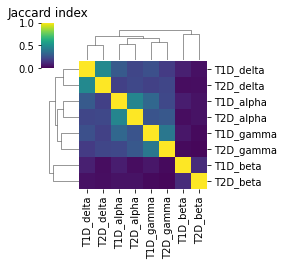

In [111]:
# Plot overlap
g=sb.clustermap(overlap,cmap='viridis',figsize=(3.5,3.5),vmin=0,vmax=1)
g.ax_cbar.set_title('Jaccard index')
g.ax_cbar.yaxis.set_ticks_position("left")
plt.savefig(path_fig+'heatmap_atlas_endoDEcomparison.png',dpi=300,bbox_inches='tight')

Same as above, but separately for up and down genes

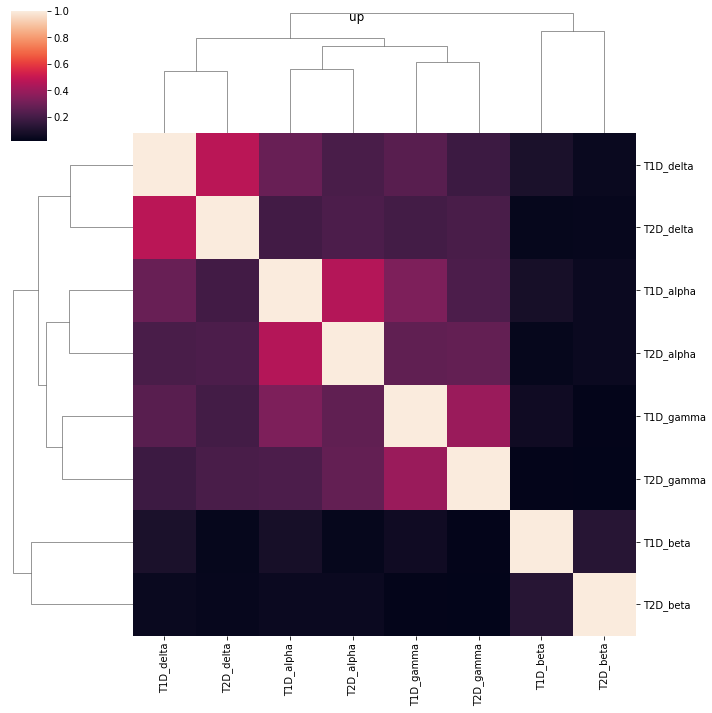

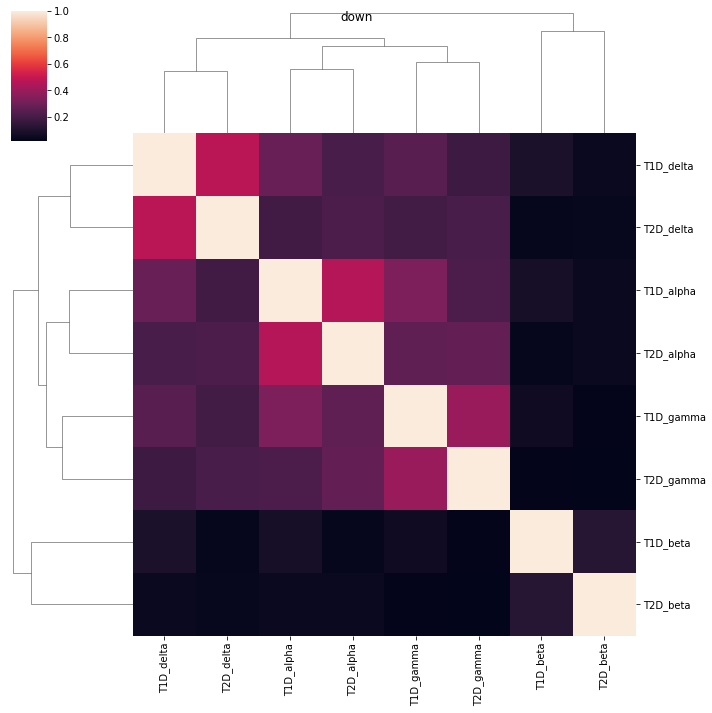

In [94]:
# Overlap of DE genes per direction
for direction in ['up','down']:
    overlap=pd.DataFrame()
    for idx1 in range(de_combined.shape[1]-1):
        for idx2 in range(idx1+1,de_combined.shape[1]):
            name1=de_combined.columns[idx1]
            name2=de_combined.columns[idx2]
            # Jaccard
            is1=set(de_combined.index[de_combined[name1]==direction])
            is2=set(de_combined.index[de_combined[name1]==direction])
            n=(de_combined[name1]==de_combined[name2]).sum()/len(
                set(de_combined[name1].dropna().index)|set(de_combined[name2].dropna().index))
            overlap.at[name1,name2]=n
            overlap.at[name2,name1]=n
    overlap=overlap.fillna(1)
    g=sb.clustermap(overlap)
    g.fig.suptitle(direction)

### Gens jointly DE in T1D and T2D in alpha, gamma, and delta

#### Enrichment

In [10]:
# Ref genes - present in all var
# All summaries have the same set of genes
ref=set.intersection(*[set(s.index) for s1 in summaries.values() for s in s1.values()])
ref=var.loc[ref,'gene_symbol'].to_list()
ro.globalenv['ref']=ref

Find alpha,dleta,gamma overlapping genes and on top overlaping do enrichment to find what is shared.

In [12]:
# Genes DE in each ct (excluding beta) and diabetes type
rce=0.1
de_genes=defaultdict(list)
for dt,s1 in summaries.items():
    for ct,summary in s1.items():
        if ct!='beta':
            de_genes['up'].extend(summary.query(
                'padj<@FDR & logFC>@ALFC & relative_ct_expression>@rce').index.values)
            de_genes['down'].extend(summary.query(
                'padj<@FDR & logFC<-@ALFC & relative_ct_expression>@rce').index.values)
for k,v in de_genes.items():
    de_genes[k]=pd.Series(v)

In [13]:
# Shared in alpha, delta, gamma and T1D/T2D
for direction,des in de_genes.items():
    counts=des.value_counts()
    print(direction,'shared all:',(counts==6).sum())
    print(set(var.loc[counts[counts==6].index,'gene_symbol']))

up shared all: 64
{'Lhx1', 'Pclo', 'Zfp346', 'Dnajc24', 'Pnmal1', 'Nbas', 'Slc35b4', 'Lrrn1', 'Ndufs2', 'Tmtc3', 'Atp2a2', 'Ins1', 'Creg1', 'H2bc6', 'Reps2', 'Gpr45', 'Xk', 'Sorbs2', 'Nrtn', 'Madd', 'Vegfa', 'Fmnl2', 'Ins2', 'Uggt1', 'Mrgpre', 'Vps13c', 'Syt13', 'Nceh1', 'Vdr', 'Zdhhc2', 'Elapor2', 'Mia3', 'Gm30648', 'Atp2a3', 'Dhrs4', 'Mitf', 'Cln6', 'AW549877', 'Aqp11', 'H4c9', 'Phactr1', 'Slc4a7', 'Slc41a3', 'Iapp', 'Pacc1', 'Cerk', 'Chic1', 'Sdf2l1', 'Kdm2b', 'Dcaf12l1', 'Sel1l', 'Ttc28', 'Hyou1', 'Vps8', 'Nfe2l1', 'Gng12', 'Rbm15b', 'Hs3st6', 'Cryl1', 'Reep6', 'Cyb5b', 'Sesn2', 'Sgpp2', 'Abitram'}
down shared all: 189
{'Scn2b', 'Cd151', 'Cst3', 'Baiap2l1', 'Cd81', 'Schip1', 'Hmgb3', 'Sema4f', 'Mcub', 'Ffar4', 'Oxtr', 'Kctd17', 'Plin3', 'Wfdc16', 'Mia', 'Myl12a', 'Gstm7', 'Rhoc', '2310001H17Rik', 'Nefm', 'Rab26os', 'Lbp', 'Cpne8', 'Rtkn', 'Nudt10', 'Efnb3', 'Gm16638', 'Prox1os', 'Rab3c', 'Ephb2', 'Ifnlr1', 'Calb1', 'Syt16', 'Gm11837', 'Bcl2', 'Kcnj3', 'Acot4', 'Pgrmc1', 'Vsig10', '

Direction up
N genes 64
N enriched gene sets: 3
Top enriched gene sets


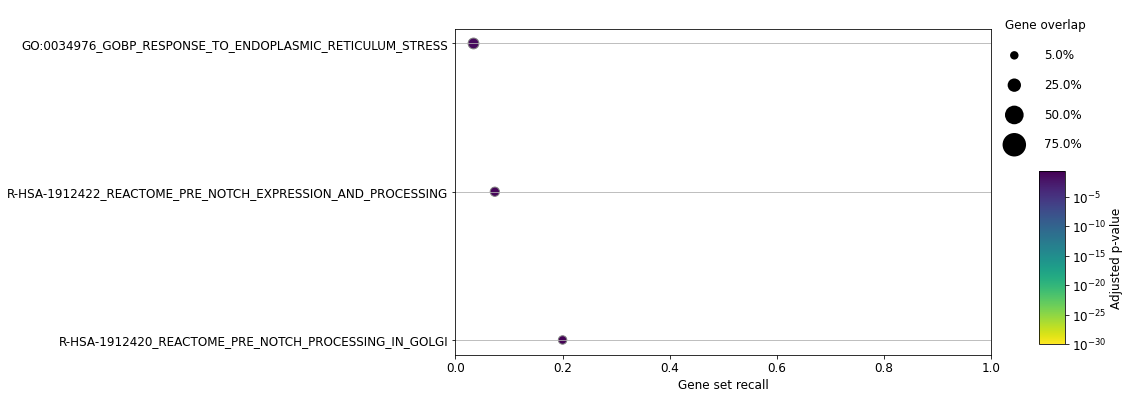

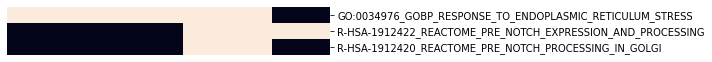

Direction down
N genes 189
N enriched gene sets: 83
Top enriched gene sets


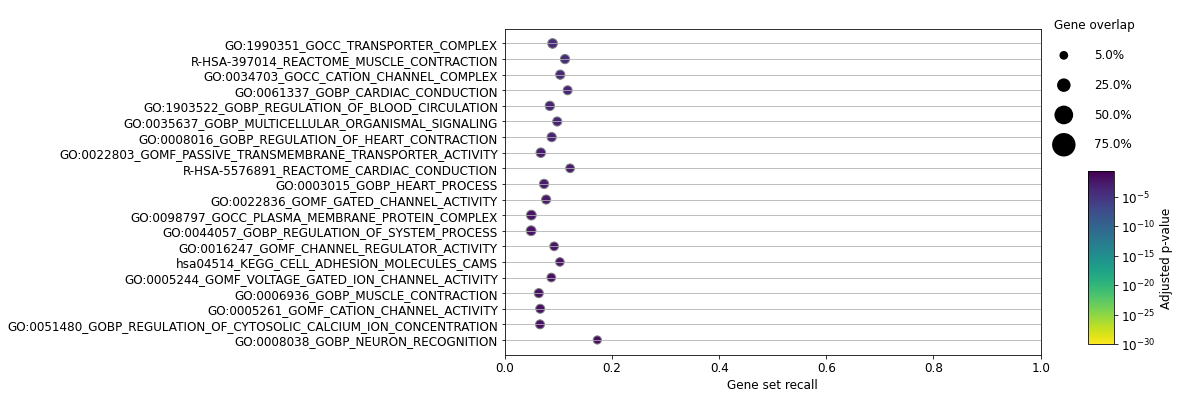

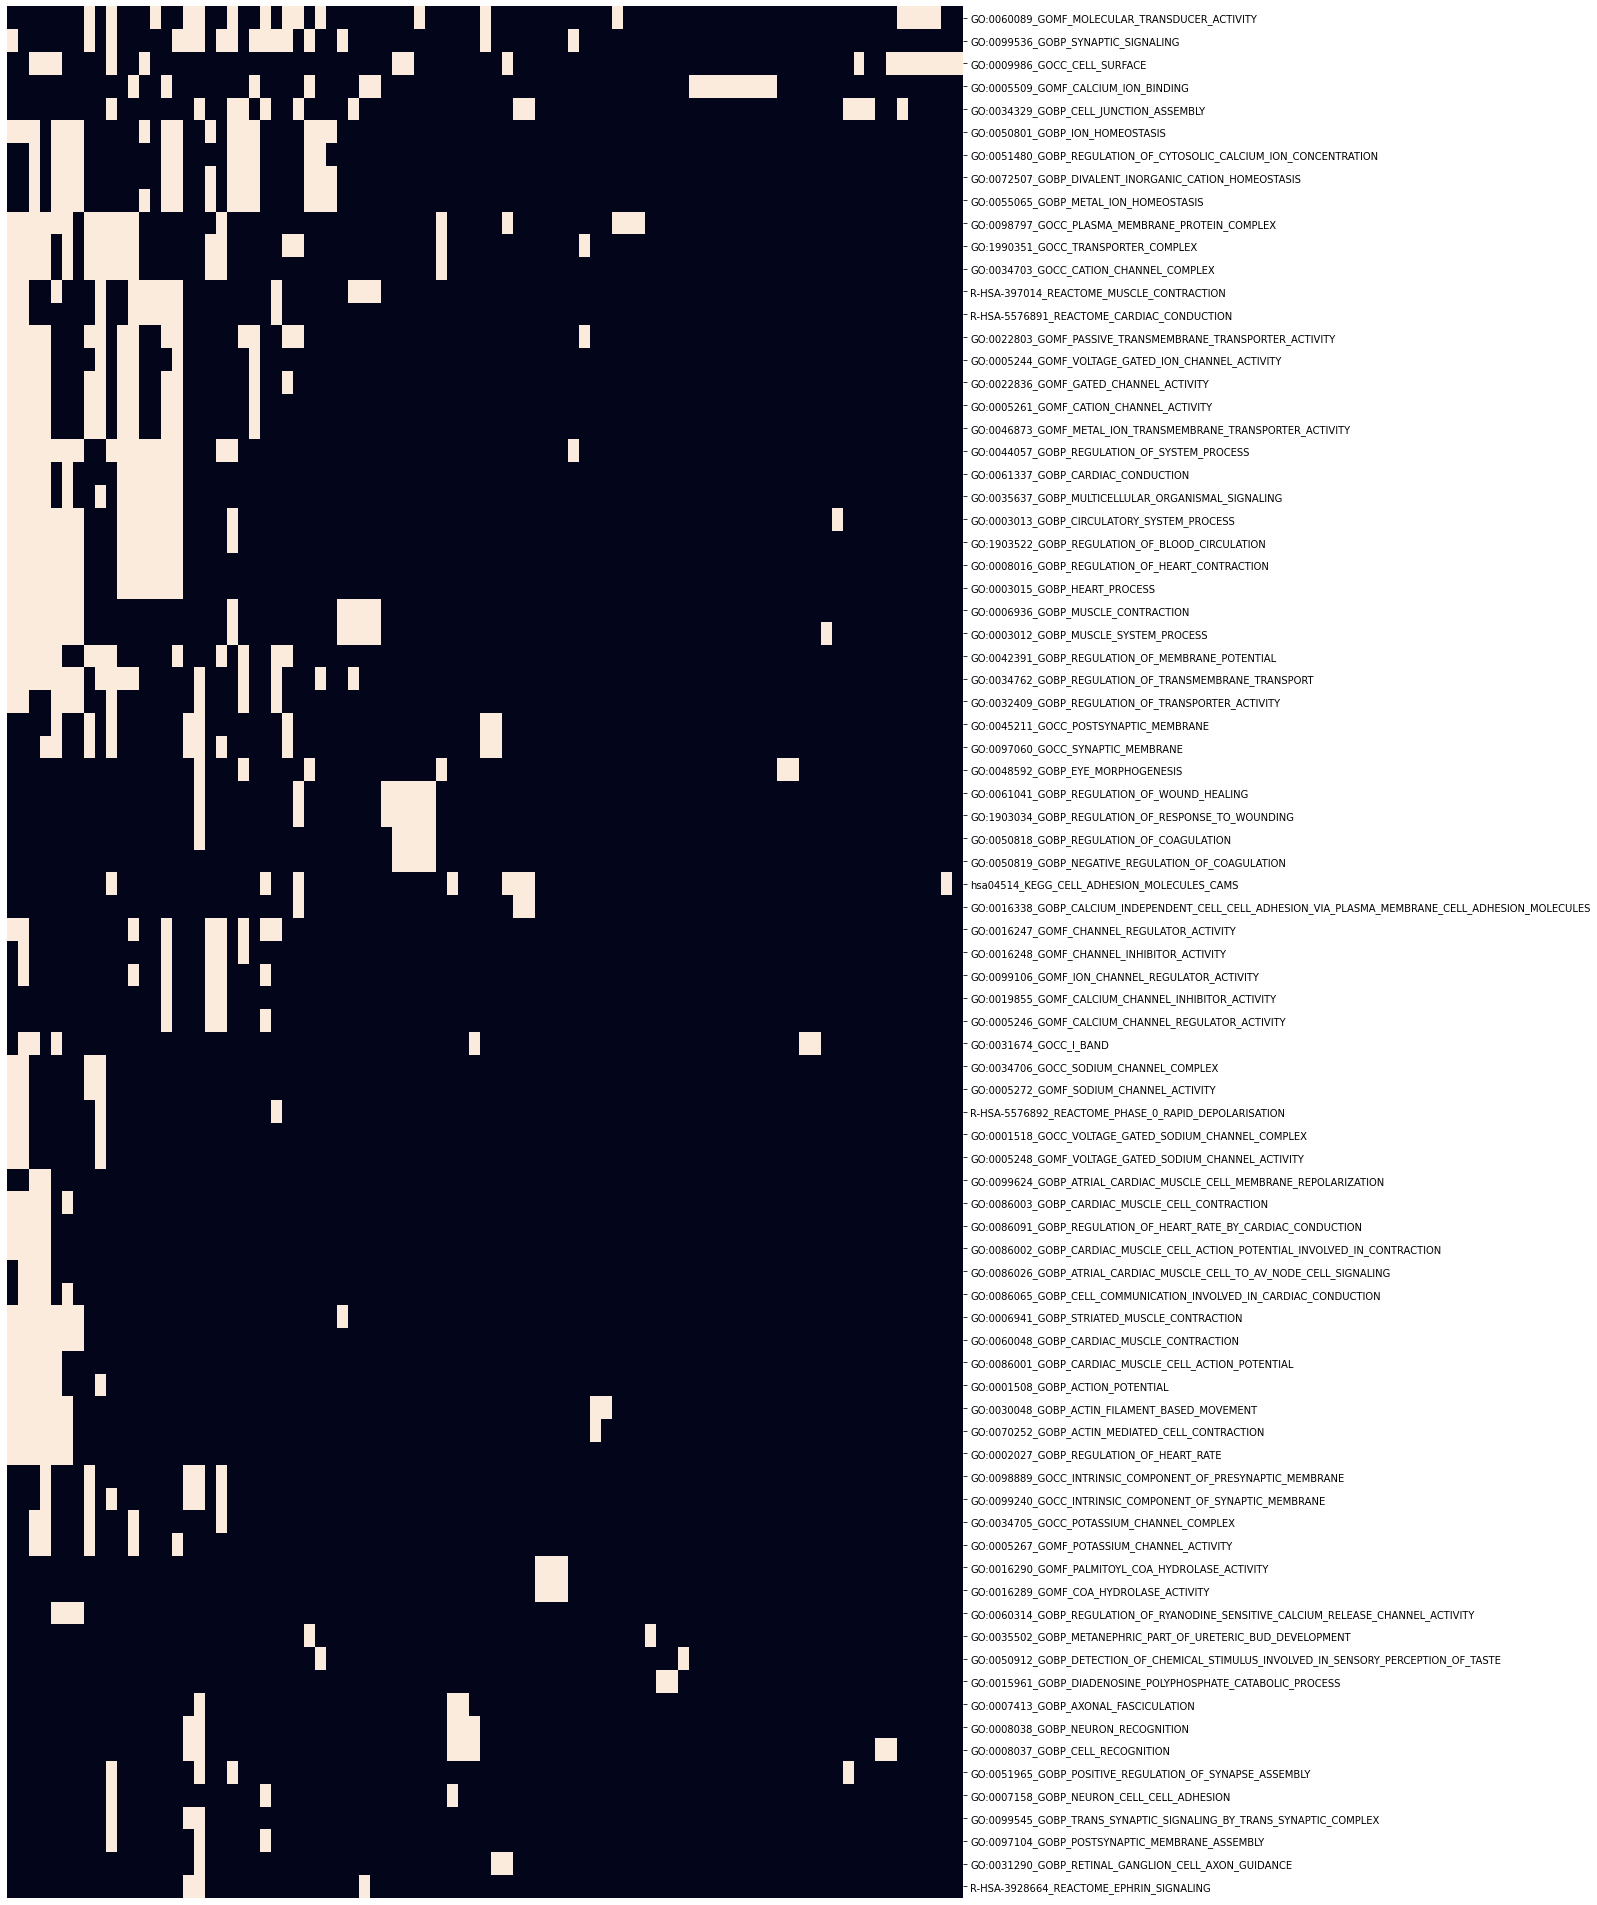

In [15]:
# Perform enrichment per cl
rce=0.1
enrich_datas={}
for direction,des in de_genes.items():
    print('Direction',direction)    
    # Query genes
    genes=des.value_counts()
    genes=genes[genes==6].index
    genes=var.loc[genes,'gene_symbol'].to_list()
    print('N genes %i'%len(genes))

    # Calculate enrichment
    enrich_fdr=0.25
    ro.globalenv['gs_fdr']=enrich_fdr
    ro.globalenv['genes']=genes
    res=ro.r(f'hypeR(signature=as.vector(unlist(genes)),genesets=gene_sets,test = "hypergeometric",background =  as.vector(unlist(ref)),pval = 1,fdr = gs_fdr,plotting = FALSE,quiet = TRUE)')
    ro.globalenv['res']=res
    data=ro.r(f'res$data')
    enrich_datas[direction]=data
    print('N enriched gene sets:',data.shape[0])

    if data.shape[0]>0:
        # Plot top enriched gene sets
        print('Top enriched gene sets')
        data['recall']=data['overlap']/data['geneset']
        data['query_size']=len(genes)
        h.plot_enrich(data=data.rename(
            {'label':'name','fdr':'p_value','overlap':'intersection_size'},axis=1),
            n_terms=20, save=False,min_pval=10**-30, max_pval=enrich_fdr,percent_size=True,
               recall_lim=(0,1))
        h.plot_enr_heatmap(data=data,n_gs=None,xticklabels=False,yticklabels=True)

# Save enrichment tables
writer = pd.ExcelWriter(path_save_r+'endoADG_shared_enrichment.xlsx',
                        engine='xlsxwriter') 
for sheet,data in enrich_datas.items():
    data.to_excel(writer, sheet_name=str(sheet))   
writer.save()

C: Up - probably ER stress, down - probably ion transport.

#### Potential ambient effects in the shared genes
Despite relative expression filtering there could be residual ambient effects (e.g. ER stress that is enriched in shared T1D/T2D A/D/G is expected to be up in diabetes in beta cells). If gene is ambiently DE it could then be DE in all other cts as well. Analyse potential beta cell contributing ambient effects.

Relative expression across endo clusters

In [46]:
rel_exprs=[]
for direction,des in de_genes.items():    
    # Query genes
    genes=des.value_counts()
    genes=genes[genes==6].index
    # Equivalent vals in T1D and T2D for reel expression
    for ct,summary in summaries['T1D'].items():
        rel_expr=pd.DataFrame(summary.loc[genes,'relative_ct_expression'])
        rel_expr['cell_type']=ct
        rel_expr['direction']=direction
        rel_exprs.append(rel_expr)
rel_exprs=pd.concat(rel_exprs)

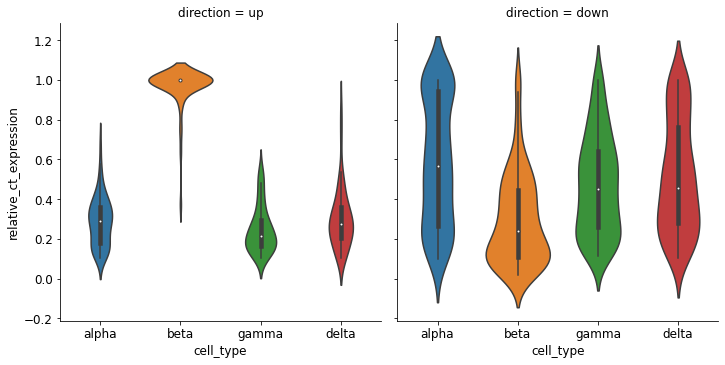

In [48]:
sb.catplot(kind='violin',x='cell_type',y='relative_ct_expression',col='direction',data=rel_exprs)

C: The shared up genes are strongly expressed in beta cells and lowly in other cts which colud indicate ambience. The down genes look better.

Distn of lFCs of DE genes in beta cells in T1D and T2D. If genes are DE due to beta ambience the lFC is expected to be in the same direction. Thus plot lFC of the shared DE genes from beta T1D and T2D comparisons.

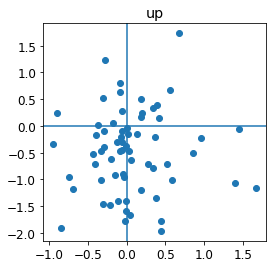

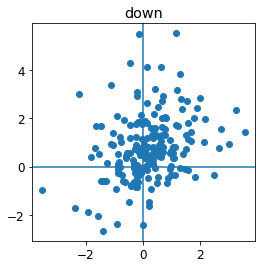

In [51]:
for direction,des in de_genes.items():    
    # Query genes
    genes=des.value_counts()
    genes=genes[genes==6].index
    fig,ax=plt.subplots(figsize=(4,4))
    plt.scatter(summaries['T1D']['beta'].loc[genes,'logFC'],
                summaries['T2D']['beta'].loc[genes,'logFC'])
    plt.title(direction)
    plt.axhline(0)
    plt.axvline(0)

C: Beta DE results do not seem to have lFC that could lead to ambient DE in other endo cts. Low relative expr may be due to the way rel is calculated - maybe affected by clustering. - e.g. May be up only in a subset of cells which are not forming a separate cluster so expression is "dilluted" out. 

## Save table for paper

In [11]:
# Add gene symbol
for dt,summaries_sub in summaries.items():
    for ct,data in summaries_sub.items():
        data['gene_symbol']=var.loc[data.index,'gene_symbol']

In [13]:
# Save De summaries in excel format for paper with parsed ct names
writer = pd.ExcelWriter(file+'summaries.xlsx',
                        engine='xlsxwriter') 
for dt,summaries_sub in summaries.items():
    for ct,data in summaries_sub.items():
        # Add data to De summary
        data.to_excel(writer, sheet_name=str(ct+'_'+dt))   
writer.save()

In [14]:
file+'summaries.xlsx'

'/lustre/groups/ml01/workspace/karin.hrovatin/data/pancreas/scRNA/combined/de/deR_endocrine/endo_summaries.xlsx'